# Ambiente

## Instalar Librerías

In [1]:
# pip install --user -r ./requirements.txt -q

In [2]:
# pip show langchain

In [3]:
# pip install --upgrade langchain -q

## Configurar dotenv

In [4]:
import os
from dotenv import load_dotenv, find_dotenv

In [5]:
load_dotenv(find_dotenv(), override=True)

True

## Imports

In [7]:
import pandas as pd
import numpy as np
import time

In [8]:
# Creación de domuentos
from langchain_core.documents import Document

# Crear índice en pinecone
from pinecone import Pinecone
from pinecone import ServerlessSpec

# Encodear y guardar documentos
from langchain_openai import OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore

# Chain respuesta a query
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# Vectorización
from concurrent.futures import ThreadPoolExecutor

# Paralelizar
from joblib import Parallel, delayed

# El documento entregado a ragas debe ser de tipo DatasetDict
from datasets import Dataset, DatasetDict

# Métricas LLM
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
    context_relevancy,
)

# Ver resultados
from ragas import evaluate

import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
model_embedding = 'text-embedding-3-large'
# model_embedding = 'text-embedding-3-small'

model_llm = "gpt-3.5-turbo"
# model_llm = 'gpt-4o'

# Documentos

## Carga

In [11]:
df_documentos = pd.read_excel('FAQS Preguntas frecuentes Abril 2024-1.xlsx', engine='openpyxl')
columnas = df_documentos.columns
df_documentos[columnas[0]] = df_documentos[columnas[0]].ffill()

In [12]:
df_documentos.head(12)

,Catalogo de respuestas frecuentes,PREGUNTA FRECUENTE,Respuesta Chat GPT
0,Portal de Servicios en Línea,¿Cómo accedo al portal de Servicios en Línea?,🌟 ¡Hola! Estamos encantados de que estés aquí....
1,Portal de Servicios en Línea,¿Cómo puedo consultar el Boletín / Boleta de C...,🌟 ¡Hola! Estamos emocionados de poder ayudarte...
2,Portal de Servicios en Línea,¿Cómo puedo consultar mi Horario?,🌟 ¡Hola! ¡Estamos aquí para ayudarte! 😊 Si nec...
3,Portal de Servicios en Línea,¿Cómo puedo recuperar mi contraseña de acceso ...,"🌟 ¡Hola! Si necesitas recuperar tu contraseña,..."
4,Becas,¿Cómo accedo al portal de Becas?,🌟 ¡Hola! Estamos encantados de ayudarte. 😊 Par...
5,Becas,¿Cómo puedo consultar mi dictamen?,📧 Recibirás una notificación en tu correo inst...
6,Becas,¿Cómo registrar un caso especial de beca?,"🎓 Para solicitar una beca por caso especial, s..."
7,Becas,¿Cómo puedo recuperar mi contraseña de acceso ...,"🔒 Si olvidaste tu contraseña, no te preocupes...."
8,Becas,¿Cuál es el promedio mínimo para conservar la ...,"🎓 Para licenciatura, es importante mantener un..."
9,Becas,¿Cuáles son los requisitos del proceso de reno...,📝 El proceso de renovación de beca consta de d...


Consideraremos como documento cada una de las filas con estructura:

```python
docs = [
    Document(
        page_content="A bunch of scientists bring back dinosaurs and mayhem breaks loose",
        metadata={"year": 1993, "rating": 7.7, "genre": ["action", "science fiction"]},
    ),
]


In [13]:
documents = []
for index, row in df_documentos.iterrows():
    elemento1 = row[columnas[0]]
    elemento2 = row[columnas[1]]
    elemento3 = row[columnas[2]]
    documento = Document(page_content=f'{elemento3}.',
                         metadata={'Categoría': f'{elemento1}', 'Pregunta': f'{elemento2}'})
    documents.append(documento)

print(documents[0].page_content)
print('\n')
print(documents[0].metadata)

🌟 ¡Hola! Estamos encantados de que estés aquí. 😊 Para acceder a nuestro portal, simplemente haz clic en este enlace:

🔗 https://ventanillaservicios.uvmnet.edu/PortalServicios/

🔐 Para iniciar sesión, utiliza tu número de matrícula como usuario y tu fecha de nacimiento en formato ddmmaa como contraseña (no olvides los dos últimos dígitos para representar el año). ¡Esperamos que tu experiencia en nuestro portal sea excelente! 👍.


{'Categoría': 'Portal de Servicios en Línea', 'Pregunta': '¿Cómo accedo al portal de Servicios en Línea?'}


## Pinecone

In [14]:
pc = Pinecone(api_key=os.environ.get("PINECONE_API_KEY"))

Borramos todos los índices creados previamente

In [15]:
for index_name in pc.list_indexes().names():
    pc.delete_index(index_name)

Creamos índice en Pinecone

In [16]:
cloud = os.environ.get('PINECONE_CLOUD') or 'aws'
region = os.environ.get('PINECONE_REGION') or 'us-east-1'

spec = ServerlessSpec(cloud=cloud, region=region)

index_name = 'lab-mod-2'

In [17]:
dimension = 3072 # text-embedding-3-large
if model_embedding == 'text-embedding-3-small':
    dimension = 1536

if index_name not in pc.list_indexes().names():
    print(f"El indice {index_name} no existe")
    print("Creando el indice...")
    pc.create_index(
            index_name,
            dimension=dimension,
            metric='cosine',
            spec=spec
        )
    print("Listo!!")
else:
    print(f"el indice {index_name} ya existe en Pinecone")


while not pc.describe_index(index_name).status['ready']:
    time.sleep(1)

El indice lab-mod-2 no existe
Creando el indice...
Listo!!


In [18]:
pc.list_indexes()

{'indexes': [{'dimension': 3072,
              'host': 'lab-mod-2-nhvaax3.svc.aped-4627-b74a.pinecone.io',
              'metric': 'cosine',
              'name': 'lab-mod-2',
              'spec': {'serverless': {'cloud': 'aws', 'region': 'us-east-1'}},
              'status': {'ready': True, 'state': 'Ready'}}]}

In [19]:
index = pc.Index(index_name)
time.sleep(1)

index.describe_index_stats()

{'dimension': 3072,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

### Encodeamos y guardamos los documentos


In [20]:
embeddings = OpenAIEmbeddings(
    model=model_embedding,
    openai_api_key=os.environ.get('OPENAI_API_KEY')
)

vectorstore = PineconeVectorStore.from_documents(
    documents, embeddings, index_name=index_name
)

In [21]:
index.describe_index_stats()

{'dimension': 3072,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 128}},
 'total_vector_count': 128}

# RAG

In [22]:
k = 3

prompt = ChatPromptTemplate.from_template(
    """Responde la siguiente pregunta de manera completa y basándote solo en el contexto proporcionado:

<contexto>
{context}
</contexto>

Pregunta: {input}"""
)

llm = ChatOpenAI(model=model_llm, temperature=1)
document_chain = create_stuff_documents_chain(llm, prompt)
retriever = vectorstore.as_retriever(search_type = 'similarity', search_kwargs={'k' : k})
retrieval_chain = create_retrieval_chain(retriever, document_chain)

In [23]:
query = 'Cómo recupero contra??'
retrieval_chain.invoke({"input": f'{query}'})

{'input': 'Cómo recupero contra??',
 'context': [Document(page_content='🔐 ¡Recuperar tu contraseña es muy fácil! Sigue estos pasos:\n\n1️⃣ Ingresa a esta liga: https://ventanillaservicios.uvmnet.edu/portalservicios/Paginas/RecuperacionDeContrase%C3%B1a.aspx \n2️⃣ En el apartado de "Cuenta", ingresa tu matrícula.\n3️⃣ En "Campus", selecciona "ONLINE".\n4️⃣ ¡Listo! Recibirás un mensaje confirmando que se ha enviado el enlace de restablecimiento a tu dirección de correo personal registrada.\n5️⃣ Revisa tu bandeja de entrada (¡y también la de spam!) en un plazo de 2 a 5 minutos para encontrar el correo con el enlace de recuperación de acceso o los detalles de inicio de sesión.\n\n¡Esperamos que recuperes tu acceso pronto! 😊🔑.', metadata={'Categoría': 'Conexión UVM', 'Pregunta': '¿Cómo puedo recuperar mi contraseña de acceso de Conexión UVM?'}),
  Document(page_content='🌟 ¡Hola! Si necesitas recuperar tu contraseña, estamos aquí para ayudarte. 😊 Simplemente haz clic en este enlace:\n\n🔗 htt

# Benchmark

Para facilitar el cálculo de las métricas verde y optimizar el uso de la memoria, agregamos columna de pregunta asociada

In [24]:
df_bench = pd.read_excel("benchmark.xlsx")
df_bench["Pregunta_asociada"] = df_bench["Documento asociado"].apply(lambda entero: df_documentos.iloc[entero]["PREGUNTA FRECUENTE"])
df_bench.head()

,pregunta,Documento asociado,Pregunta_asociada
0,como entrar portal online servicios?,0,¿Cómo accedo al portal de Servicios en Línea?
1,¿Cómo hacer para usar Servicios en Internet?,0,¿Cómo accedo al portal de Servicios en Línea?
2,¿Cómo se accede al portal de servicios de la UVM?,0,¿Cómo accedo al portal de Servicios en Línea?
3,¿Qué información se necesita para iniciar sesi...,0,¿Cómo accedo al portal de Servicios en Línea?
4,Como consutar calificaciones?,1,¿Cómo puedo consultar el Boletín / Boleta de C...


# Metricas Verdes

## Definición y ejemplos de uso

In [25]:
k_ejemplos = 10

In [26]:
q = df_bench.iloc[0]["pregunta"]
print(q)

df_bench.head(2)

como entrar portal online servicios?


,pregunta,Documento asociado,Pregunta_asociada
0,como entrar portal online servicios?,0,¿Cómo accedo al portal de Servicios en Línea?
1,¿Cómo hacer para usar Servicios en Internet?,0,¿Cómo accedo al portal de Servicios en Línea?


In [27]:
relevant_questions = df_bench.loc[df_bench["pregunta"]==q, "Pregunta_asociada"].values[0]
relevant_questions

'¿Cómo accedo al portal de Servicios en Línea?'

In [28]:
retriever = vectorstore.as_retriever(search_type = 'similarity', search_kwargs={'k': k_ejemplos})
retrieval_chain = create_retrieval_chain(retriever, document_chain)
info_answer = retrieval_chain.invoke({"input": f'{q}'})
print(info_answer)

{'input': 'como entrar portal online servicios?', 'context': [Document(page_content='🌟 ¡Bienvenido a tu portal de pago en línea! Para ingresar, simplemente haz clic en este enlace:\n\n🔗 https://uvmenlinea.uvmnet.edu/ServiciosEnLineaBanner/Login.aspx \n\n🔐 Usa tu número de matrícula como usuario y tu fecha de nacimiento en formato ddmmaa como contraseña (los dos últimos dígitos son para el año). No olvides seleccionar "Online" como tu campus. ¡Listo para empezar! 😊💳.', metadata={'Categoría': 'Pago en Línea', 'Pregunta': '¿Cómo ingreso al portal de Pago en línea?'}), Document(page_content='🌟 ¡Accede al portal de manera fácil y rápida! Aquí te indicamos cómo hacerlo:\n\n1️⃣ Ingresa al portal a través de este enlace: https://uvmlink-csm.symplicity.com/ \n2️⃣ Selecciona el usuario "ESTUDIANTE/EGRESADO".\n3️⃣ Inicia sesión utilizando tu correo institucional y la contraseña correspondiente. Si experimentas algún problema de acceso, ¡no te preocupes! Contacta a un Asistente Lince para recibir 

In [29]:
question_retrieval = []
for doc in info_answer['context']:
    print(doc.metadata['Pregunta'])
    question_retrieval.append(doc.metadata['Pregunta'])

¿Cómo ingreso al portal de Pago en línea?
¿Cómo ingreso al portal de bolsa de trabajo?
¿Cómo accedo al portal de Servicios en Línea?
¿Cómo puedo ingresar al portal de ayuda?
¿Cómo accedo al portal de Becas?
¿Cuál es la liga de acceso al portal de Enseñanza Aprendizaje Blackboard?
¿Cómo puedo realizar mi pago en línea?
¿Cómo puedo ingresar a la biblioteca digital?
¿Cómo puedo consultar el Boletín / Boleta de Calificaciones?
¿Cómo puedo dar de alta mis datos fiscales para facturar?


Notamos que el tercer documento es nuestro documento relevante, por lo que debiésemos tener:
$$\textbf{success@k} = \left\{
    \begin{array}{cl} 
    0, & \text{ si } k < 3 \\ 
    1, & \text{ si } k \geq 3 
\end{array}\right.$$

In [30]:
k_list = [1, 3, 7, 10]

<div style="color: green;">
  <h3>Success</h3>
</div>

In [31]:
def Success(k, question_retrieval, q):  
    if df_bench.loc[df_bench["pregunta"] == q,"Pregunta_asociada"].values[0] in question_retrieval[:k]:
        return 1
    else:
        return 0

In [32]:
for k in k_list:
    print(f'success@{k} = {Success(k, question_retrieval, q)}')

success@1 = 0
success@3 = 1
success@7 = 1
success@10 = 1


<div style="color: green;">
  <h3>RR: Reciprocal Rank</h3>
</div>

In [33]:
def RR(k, question_retrieval, q):
    try:
        index = question_retrieval[:k].index(df_bench.loc[df_bench["pregunta"]==q, "Pregunta_asociada"].values[0])
        return 1 / (index + 1)
    except ValueError:
        return 0

In [34]:
for k in k_list:
    print(f'RR@{k} = {RR(k, question_retrieval, q)}')

RR@1 = 0
RR@3 = 0.3333333333333333
RR@7 = 0.3333333333333333
RR@10 = 0.3333333333333333


<div style="color: green;">
  <h3>MRR: Mean Reciprocal Rank</h3>
</div>

In [35]:
def MRR(k, question_retrievals, Q):
    rr_values = []
    for i in range(len(Q)):
        rr_values.append(RR(k, question_retrievals[i], Q[i]))
    if rr_values:
        return sum(rr_values) / len(Q)
    else:
        return 0

Para probar esto agregaremos otra query de ejemplo

In [36]:
q2 = df_bench.iloc[1]["pregunta"]
print(q2)

df_bench.head(2)

¿Cómo hacer para usar Servicios en Internet?


,pregunta,Documento asociado,Pregunta_asociada
0,como entrar portal online servicios?,0,¿Cómo accedo al portal de Servicios en Línea?
1,¿Cómo hacer para usar Servicios en Internet?,0,¿Cómo accedo al portal de Servicios en Línea?


In [37]:
retriever = vectorstore.as_retriever(search_type = 'similarity', search_kwargs={'k': k_ejemplos})
retrieval_chain = create_retrieval_chain(retriever, document_chain)
info_answer = retrieval_chain.invoke({"input": f'{q2}'})

question_retrieval2 = []
for doc in info_answer['context']:
    print(doc.metadata['Pregunta'])
    question_retrieval2.append(doc.metadata['Pregunta'])

¿Cómo ingreso a la plataforma con la opción de SafeKey?
¿Cuál es el proceso para iniciar con mi servicio social?
¿Cómo puedo ingresar al portal de ayuda?
¿Cómo ingreso al portal de bolsa de trabajo?
¿Cómo puedo ingresar a la biblioteca digital?
¿Cómo puedo dar de alta mis datos fiscales para facturar?
¿Cómo accedo al portal de Servicios en Línea?
¿Cómo puedo consultar el Boletín / Boleta de Calificaciones?
¿Cómo puedo consultar mi Horario?
¿Cómo puedo realizar mi pago en Conexión UVM?


In [38]:
# Aquí la posición del documento relevante es 7
for k in k_list:
    print(f'RR@{k} = {RR(k, question_retrieval2, q2)}')

RR@1 = 0
RR@3 = 0
RR@7 = 0.14285714285714285
RR@10 = 0.14285714285714285


In [39]:
# Tenemos un rank 3 y otro 7
for k in k_list:
    print(f'MRR@{k} = {MRR(k, [question_retrieval, question_retrieval2], [q, q2])}')

MRR@1 = 0.0
MRR@3 = 0.16666666666666666
MRR@7 = 0.23809523809523808
MRR@10 = 0.23809523809523808


<div style="color: green;">
  <h3>Precisión</h3>
</div>

In [40]:
def Precision(k, question_retrieval, relevant_questions):
    if not isinstance(relevant_questions, list):
        relevant_questions = [relevant_questions] 
    relevant_count = sum(1 for _ in list(set(question_retrieval[:k]) & set(relevant_questions)))
    
    if k > 0:
        return relevant_count / k
    else:
        return 0

In [41]:
for k in k_list:
    print(f'Precision@{k} = {Precision(k, question_retrieval, relevant_questions)}')

Precision@1 = 0.0
Precision@3 = 0.3333333333333333
Precision@7 = 0.14285714285714285
Precision@10 = 0.1


<div style="color: green;">
  <h3>Recall</h3>
</div>

In [42]:
def Recall(k, question_retrieval, relevant_questions):
    if not isinstance(relevant_questions, list):
        relevant_questions = [relevant_questions] 
    relevant_retrieved_count = sum(1 for _ in list(set(question_retrieval[:k]) & set(relevant_questions)))
    total_relevant_count = len(relevant_questions)
    
    if total_relevant_count > 0:
        return relevant_retrieved_count / total_relevant_count
    else:
        return 0

In [43]:
for k in k_list:
    print(f'Recall@{k} = {Recall(k, question_retrieval, relevant_questions)}')

Recall@1 = 0.0
Recall@3 = 1.0
Recall@7 = 1.0
Recall@10 = 1.0


## Resultados

In [44]:
start_time_verdes = time.time()
df_result = df_bench[["pregunta","Pregunta_asociada"]]

for k in k_list:
    df_result[f"Success@{k}"] = 0
    df_result[f"RR@{k}"] = 0
    df_result[f"Precision@{k}"] = 0
    df_result[f"Recall@{k}"] = 0

def retrieve(query):
    retriever = vectorstore.as_retriever(search_type='similarity', search_kwargs={'k': 10})
    retrieval_chain = create_retrieval_chain(retriever, document_chain)
    info_answer = retrieval_chain.invoke({"input": f'{query}'})
    return [doc.metadata['Pregunta'] for doc in info_answer['context']]

queries = df_result["pregunta"].tolist()

# Paralelizar
with ThreadPoolExecutor() as executor:
    retrieved_results = list(executor.map(retrieve, queries))

df_result['retrieved_questions'] = retrieved_results

# Aplicar las métricas de evaluación de manera vectorizada
for k in k_list:
    df_result[f"Success@{k}"] = df_result.apply(lambda row: Success(k, row['retrieved_questions'], row['pregunta']), axis=1)
    df_result[f"RR@{k}"] = df_result.apply(lambda row: RR(k, row['retrieved_questions'], row['pregunta']), axis=1)
    df_result[f"Precision@{k}"] = df_result.apply(lambda row: Precision(k, row['retrieved_questions'], row['Pregunta_asociada']), axis=1)
    df_result[f"Recall@{k}"] = df_result.apply(lambda row: Recall(k, row['retrieved_questions'], row['Pregunta_asociada']), axis=1)

df_result.drop(columns=['retrieved_questions'], inplace=True)
end_time_verdes = time.time()
df_result.head()

,pregunta,Pregunta_asociada,Success@1,RR@1,Precision@1,Recall@1,Success@3,RR@3,Precision@3,Recall@3,Success@7,RR@7,Precision@7,Recall@7,Success@10,RR@10,Precision@10,Recall@10
0,como entrar portal online servicios?,¿Cómo accedo al portal de Servicios en Línea?,0,0.0,0.0,0.0,1,0.333333,0.333333,1.0,1,0.333333,0.142857,1.0,1,0.333333,0.1,1.0
1,¿Cómo hacer para usar Servicios en Internet?,¿Cómo accedo al portal de Servicios en Línea?,0,0.0,0.0,0.0,0,0.000000,0.000000,0.0,1,0.142857,0.142857,1.0,1,0.142857,0.1,1.0
2,¿Cómo se accede al portal de servicios de la UVM?,¿Cómo accedo al portal de Servicios en Línea?,1,1.0,1.0,1.0,1,1.000000,0.333333,1.0,1,1.000000,0.142857,1.0,1,1.000000,0.1,1.0
3,¿Qué información se necesita para iniciar sesi...,¿Cómo accedo al portal de Servicios en Línea?,0,0.0,0.0,0.0,0,0.000000,0.000000,0.0,1,0.250000,0.142857,1.0,1,0.250000,0.1,1.0
4,Como consutar calificaciones?,¿Cómo puedo consultar el Boletín / Boleta de C...,1,1.0,1.0,1.0,1,1.000000,0.333333,1.0,1,1.000000,0.142857,1.0,1,1.000000,0.1,1.0


In [45]:
for k in k_list:
    print(f'{k = }')
    print(f'sum(success@{k}) = {df_result[f'Success@{k}'].sum()}')
    print(f'sum(recall@{k}) = {df_result[f'Recall@{k}'].sum()}') # Debiesen ser iguales pues solo tenemos 1 documento relevante
    print(f'MRR@{k} = {df_result[f'RR@{k}'].sum()/len(df_result) }')
    print('----------------------------------------------------\n')

k = 1
sum(success@1) = 378
sum(recall@1) = 378.0
MRR@1 = 0.6342281879194631
----------------------------------------------------

k = 3
sum(success@3) = 484
sum(recall@3) = 484.0
MRR@3 = 0.7161633109619687
----------------------------------------------------

k = 7
sum(success@7) = 536
sum(recall@7) = 536.0
MRR@7 = 0.7346077021412591
----------------------------------------------------

k = 10
sum(success@10) = 551
sum(recall@10) = 551.0
MRR@10 = 0.7375952114626612
----------------------------------------------------



In [46]:
len(df_result)

596

In [47]:
df_result.to_csv(f'métricas_verdes/métricas_verdes_{model_embedding}_{model_llm}.csv', sep=',')

# Métricas LLM

In [48]:
# En caso de que les de error con default_ciphers, borrar esta linea y descomentar la linea de abajo
# pip install requests "urllib3<2"

In [49]:
df_ragas = df_bench[["pregunta"]]
df_ragas = df_ragas.rename(columns={"pregunta":"question"})

df_ragas["contexts"] = None 
df_ragas["answer"] = None 

df_ragas.head()

,question,contexts,answer
0,como entrar portal online servicios?,None,None
1,¿Cómo hacer para usar Servicios en Internet?,None,None
2,¿Cómo se accede al portal de servicios de la UVM?,None,None
3,¿Qué información se necesita para iniciar sesi...,None,None
4,Como consutar calificaciones?,None,None


In [50]:
# # Primeros 5 para disminuir el tiempo que se demora
# df_ragas = df_ragas.head(5)

In [51]:
start_time_llm = time.time()

def retrieve_and_answer(query):
    info_answer = retrieval_chain.invoke({"input": f'{query}'})
    contexts = [document.page_content for document in info_answer["context"]]
    return contexts, info_answer["answer"]

with ThreadPoolExecutor() as executor:
    results = list(executor.map(retrieve_and_answer, df_ragas['question'].tolist()))

contexts_answers_df = pd.DataFrame(results, columns=['contexts', 'answer'])

df_ragas[['contexts', 'answer']] = contexts_answers_df

df_ragas.head()

,question,contexts,answer
0,como entrar portal online servicios?,[🌟 ¡Bienvenido a tu portal de pago en línea! P...,"Para acceder al portal de servicios en línea, ..."
1,¿Cómo hacer para usar Servicios en Internet?,"[Para iniciar sesión con SafeKey, primero aseg...",Para usar los servicios en internet que ofrece...
2,¿Cómo se accede al portal de servicios de la UVM?,[🌟 ¡Hola! Estamos encantados de que estés aquí...,"Para acceder al portal de servicios de la UVM,..."
3,¿Qué información se necesita para iniciar sesi...,"[Para iniciar sesión por primera vez, simpleme...",Para iniciar sesión en el portal se necesita i...
4,Como consutar calificaciones?,[🌟 ¡Hola! Estamos emocionados de poder ayudart...,"Para consultar tus calificaciones, primero deb..."


In [52]:
# Visualizacion 
# for query in df_ragas["question"]:
#    print(df_bench.loc[df_bench["pregunta"]==query,"Pregunta_asociada"].values[0])

In [53]:
# Mas visualizacion
# for query in df_ragas["question"]:
#    print(df_bench.loc[df_bench["pregunta"]==query,"Pregunta_asociada"].values[0])
#    print(f'la query es{query} y el documento es {df.loc[df["PREGUNTA FRECUENTE"]==df_bench.loc[df_bench["pregunta"]==query,"Pregunta_asociada"].values[0],"Respuesta Chat GPT"].values}')

In [54]:
df_ragas["ground_truth"] = df_ragas["question"].apply(lambda query: df_documentos.loc[df_documentos["PREGUNTA FRECUENTE"]==df_bench.loc[df_bench["pregunta"]==query,"Pregunta_asociada"].values[0],"Respuesta Chat GPT"].values[0])
df_ragas.head()

,question,contexts,answer,ground_truth
0,como entrar portal online servicios?,[🌟 ¡Bienvenido a tu portal de pago en línea! P...,"Para acceder al portal de servicios en línea, ...",🌟 ¡Hola! Estamos encantados de que estés aquí....
1,¿Cómo hacer para usar Servicios en Internet?,"[Para iniciar sesión con SafeKey, primero aseg...",Para usar los servicios en internet que ofrece...,🌟 ¡Hola! Estamos encantados de que estés aquí....
2,¿Cómo se accede al portal de servicios de la UVM?,[🌟 ¡Hola! Estamos encantados de que estés aquí...,"Para acceder al portal de servicios de la UVM,...",🌟 ¡Hola! Estamos encantados de que estés aquí....
3,¿Qué información se necesita para iniciar sesi...,"[Para iniciar sesión por primera vez, simpleme...",Para iniciar sesión en el portal se necesita i...,🌟 ¡Hola! Estamos encantados de que estés aquí....
4,Como consutar calificaciones?,[🌟 ¡Hola! Estamos emocionados de poder ayudart...,"Para consultar tus calificaciones, primero deb...",🌟 ¡Hola! Estamos emocionados de poder ayudarte...


In [55]:
df_ragas.to_csv(f'df_ragas/df_ragas_{model_embedding}_{model_llm}.csv', sep=',')

In [56]:
dataset_dict = DatasetDict({'eval': Dataset.from_pandas(df_ragas)})
dataset_dict

DatasetDict({
    eval: Dataset({
        features: ['question', 'contexts', 'answer', 'ground_truth'],
        num_rows: 596
    })
})

In [60]:
result = evaluate(
    dataset_dict["eval"],
    metrics=[
        context_precision,
        faithfulness,
        answer_relevancy,
        context_recall,
        context_relevancy
    ],
)

end_time_llm = time.time()

result

Evaluating:   0%|          | 0/2980 [00:00<?, ?it/s]

No statements were generated from the answer.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.


{'context_precision': 0.8775, 'faithfulness': 0.8803, 'answer_relevancy': 0.7808, 'context_recall': 0.8077, 'context_relevancy': 0.0317}

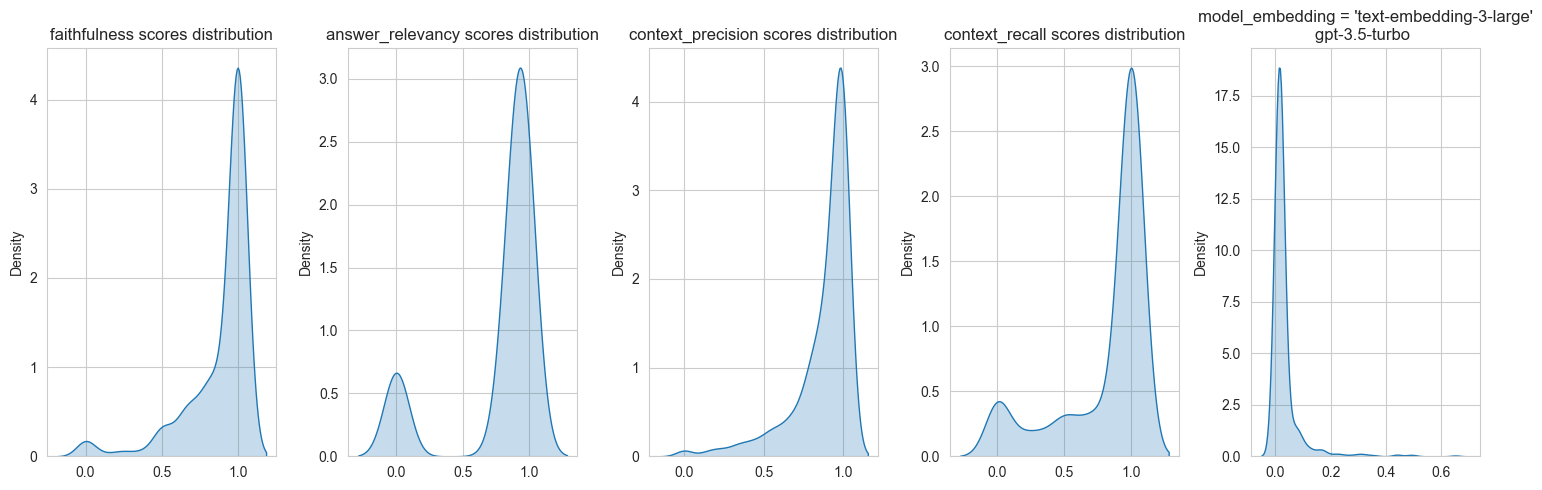

In [61]:
result_df = result.to_pandas()
result_df.to_csv(f'métricas_llm/métricas_llm_{model_embedding}_{model_llm}.csv', sep=',')

def analysis(result_df):
    sns.set_style("whitegrid")
    fig, axs = plt.subplots(1,5, figsize=(15, 5))
    for i,col in enumerate(result_df.columns):
        sns.kdeplot(data=[result_df[col].values],legend=False,ax=axs[i],fill=True)
        axs[i].set_title(f'{col} scores distribution')
        # axs[i].legend(labels=["falcon"])
    plt.title(f'{model_embedding = }\n{model_llm} ')
    plt.tight_layout()
    plt.show()

analysis(
    result_df[['faithfulness', 'answer_relevancy', 'context_precision', 'context_recall', 'context_relevancy']],
)

# Tiempos de ejecución

In [62]:
# total de ejecución
total_time_seconds = end_time_verdes - start_time_verdes

# a minutos y horas
total_time_minutes = total_time_seconds / 60
total_time_hours = total_time_minutes / 60

print(f"Tiempo total de ejecución métricas retriever: {total_time_seconds:.2f} segundos")
print(f"Tiempo total de ejecución métricas retriever: {total_time_minutes:.2f} minutos")
print(f"Tiempo total de ejecución métricas retriever: {total_time_hours:.2f} horas")

Tiempo total de ejecución métricas retriever: 129.02 segundos
Tiempo total de ejecución métricas retriever: 2.15 minutos
Tiempo total de ejecución métricas retriever: 0.04 horas


In [63]:
# total de ejecución
total_time_seconds = end_time_llm - start_time_llm

# a minutos y horas
total_time_minutes = total_time_seconds / 60
total_time_hours = total_time_minutes / 60

print(f"Tiempo total de ejecución métricas llm: {total_time_seconds:.2f} segundos")
print(f"Tiempo total de ejecución métricas llm: {total_time_minutes:.2f} minutos")
print(f"Tiempo total de ejecución métricas llm: {total_time_hours:.2f} horas")

Tiempo total de ejecución métricas llm: 1282.73 segundos
Tiempo total de ejecución métricas llm: 21.38 minutos
Tiempo total de ejecución métricas llm: 0.36 horas


: 